# Cryptocurrency portfolio analyzer

This notebook is written to analyze the current state of one's cryptocurrency portfolio, fetching the latest market information via the coinmarketcap.com API and displaying the latest development in convenient statistics and plots.

In [1]:
# package header
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
plt.style.use('fivethirtyeight')

In [2]:
# input parameters
portfolio_file = "my_portfolio_example.dat"
currency = 'EUR'
# portfolio demo data (corresponds to investing $100 in each Top 10 currenncy on October 1st, 2017)
portfolio_demo = {'BTC': 0.02315704, 'ETH': 0.33462723, 'XRP': 505.54328209, 'BCH': 0.23324159, 'LTC': 1.83789745, 
                  'DASH': 0.30811893, 'XEM': 427.30112337, 'MIOTA': 162.01206018, 'NEO': 3.03490137, 'XMR': 1.05920983}
portfolio_dict = portfolio_demo
use_portfolio_dict = False

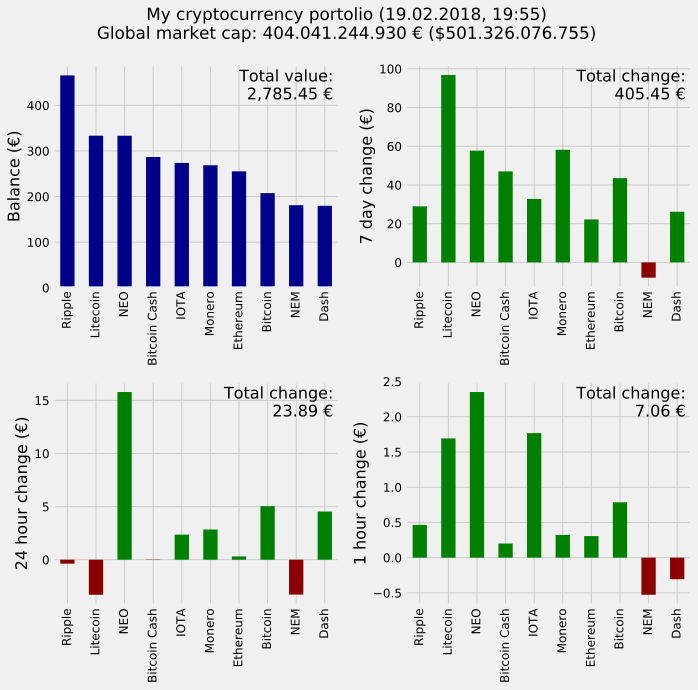

In [3]:
## Data preparation
curru = currency.upper()
currl = currency.lower()
# Use currency symbol for USD and EUR, else use normal currency code
curr_sym = '$' if curru == 'USD' else ('€' if curru == 'EUR' else curru)

# Fetch market information from coinmarketcap.com API and portfolio information from local file
global_cap = pd.read_json("https://api.coinmarketcap.com/v1/global/?convert=" + curru, typ='series')
market_cap = pd.read_json("https://api.coinmarketcap.com/v1/ticker/?limit=0&convert=" + curru)
if use_portfolio_dict:
    my_portfolio = pd.DataFrame(list(portfolio_demo.items()),columns=['coin','balance'])
else:
    my_portfolio = pd.read_csv(portfolio_file)

# Merge market and portfolio information, then generate additional columns for convenient statistics 
my_market = market_cap.merge(my_portfolio,left_on='symbol',right_on='coin',how='inner')
my_market['balance_' + currl] = my_market['balance']*my_market['price_' + currl]
my_market.sort_values('balance_' + currl,ascending=False,inplace=True)
my_balance_total = my_market['balance_' + currl].sum()

my_change_total = {}
for interval in ['7d','24h','1h']:
    my_market['balance_' + currl + '_' + interval + '_ago'] = my_market['balance_' + currl] / \
        (1 + (my_market['percent_change_' + interval] / 100))
    my_market['my_change_' + interval] = my_market['balance_' + currl] - my_market['balance_' + currl + '_' + interval + '_ago']
    my_change_total[interval] = my_market['my_change_' + interval].sum()

## Data visualization
# setting up plot and suptitle with global market information
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
stitle = 'My cryptocurrency portolio (' + datetime.datetime.now().strftime('%d.%m.%Y, %H:%M') + ')\n'
# for USD show only USD value, else show USD value in addition 
if curru == 'USD':
    stitle += 'Global market cap: ${:,.0f}'.format(global_cap.total_market_cap_usd).replace(',','.')
else:
    stitle += 'Global market cap: {0:,.0f} {1} (${2:,.0f})'.format(global_cap['total_market_cap_' + currl], 
                    curr_sym, global_cap.total_market_cap_usd).replace(',','.')
fig.suptitle(stitle)

# plotting portfolio development 
# plot for current balance per coin
my_market.plot.bar(ax=ax[0,0],x='name',y='balance_' + currl,color='darkblue',legend=False,fontsize=12)

# helper function to choose change colors
def get_change_color(change_list):
    return ['green' if x > 0 else 'darkred' for x in change_list]

# plots for 7d, 24h and 1h changes per coin
my_market.plot.bar(ax=ax[0,1],x='name',y='my_change_7d',legend=False,fontsize=12,
                   color=get_change_color(my_market['my_change_7d']))
my_market.plot.bar(ax=ax[1,0],x='name',y='my_change_24h',legend=False,fontsize=12,
                   color=get_change_color(my_market['my_change_24h']))
my_market.plot.bar(ax=ax[1,1],x='name',y='my_change_1h',legend=False,fontsize=12,
                   color=get_change_color(my_market['my_change_1h']))

# setting labels 
ylabels={(0,0): 'Balance (' + curr_sym + ')', (0,1): '7 day change (' + curr_sym + ')', 
         (1,0): '24 hour change (' + curr_sym + ')', (1,1): '1 hour change (' + curr_sym + ')'}
for i,j in [(0,0),(0,1),(1,0),(1,1)]:
    ax[i,j].set_xlabel('')
    ax[i,j].set_ylabel(ylabels[i,j], fontsize=16)

# adding total numbers as additional information
ax[0,0].text(0.98,0.98,'Total value:\n{0:,.2f} {1}'.format(my_balance_total, curr_sym),
             ha='right', va='top',transform=ax[0,0].transAxes,fontsize=16)
for c in [('7d',(0,1)), ('24h',(1,0)), ('1h',(1,1))]:
    ax[c[1]].text(0.98,0.98 if my_change_total[c[0]] > 0 else 0.02,
                  'Total change:\n{0:,.2f} {1}'.format(my_change_total[c[0]], curr_sym),
                 ha='right', va='top' if my_change_total[c[0]] > 0 else 'bottom',
                  transform=ax[c[1]].transAxes,fontsize=16)
    
# last layout adjustments
plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.subplots_adjust(top=0.9)
plt.show()